# 데이터 전처리 최종 정리(다은)
##### 2020.06.02
- Null값 행 제거(pop열 중심)
- 외부데이터 합쳐서 사용 = 칼럼 수 늘림
- 누적 확진자 수 사용
- but 다중공선성 문제 해결필요


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("Health_systems.csv")
train = pd.read_csv('train.csv') # 확진자수 데이터
pop = pd.read_csv('population.csv') # 인구, 인구밀도 데이터

data.head(2)

,Country_Region,Province_State,World_Bank_Name,Health_exp_pct_GDP_2016,Health_exp_public_pct_2016,Health_exp_out_of_pocket_pct_2016,Health_exp_per_capita_USD_2016,per_capita_exp_PPP_2016,External_health_exp_pct_2016,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,Completeness_of_death_reg_2008-16
0,Afghanistan,NaN,Afghanistan,10.2,5.1,77.4,57.2,162.8,17.5,0.3,0.3,0.0,42.3,NaN
1,Albania,NaN,Albania,6.7,41.4,58.0,271.5,759.7,0.7,1.2,3.6,11.6,98.4,53.0


In [2]:
pop['pop'] = pop['pop'].str.replace(",", "").astype('float64')
pop.head(2)

,country,pop,tests,testpop,density,medianage,urbanpop,quarantine,schools,restrictions,...,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung
0,Afghanistan,38928346.0,NaN,NaN,60.0,18.0,25.0,NaN,NaN,NaN,...,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33
1,Albania,2877797.0,NaN,NaN,105.0,36.0,63.0,NaN,NaN,NaN,...,1.08,1.11,1.09,0.93,0.95,0.87,0.98,11.67,7.02,17.04


## train

In [3]:
train['Date'] = pd.to_datetime(train.Date)
train['country_province'] = train['Province_State']
train.country_province.fillna(train['Country_Region'], inplace=True)

train = train.merge(pop, how='left', left_on = ['country_province'], right_on=['country'])
train = train.merge(data, how='left', left_on=["Country_Region", "Province_State"], right_on = ["Country_Region", "Province_State"])
train["days"] = (train.Date - train.Date[0]).dt.days

from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train['label_country'] = lb.fit_transform(train.country_province)

train.head(2)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,country_province,country,pop,tests,...,Health_exp_per_capita_USD_2016,per_capita_exp_PPP_2016,External_health_exp_pct_2016,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,Completeness_of_death_reg_2008-16,days,label_country
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,Afghanistan,Afghanistan,38928346.0,NaN,...,57.2,162.8,17.5,0.3,0.3,0.0,42.3,NaN,0,0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,Afghanistan,Afghanistan,38928346.0,NaN,...,57.2,162.8,17.5,0.3,0.3,0.0,42.3,NaN,1,0


In [4]:
train.columns

Index(['Id', 'Province_State', 'Country_Region', 'Date', 'ConfirmedCases',
       'Fatalities', 'country_province', 'country', 'pop', 'tests', 'testpop',
       'density', 'medianage', 'urbanpop', 'quarantine', 'schools',
       'restrictions', 'hospibed', 'smokers', 'sex0', 'sex14', 'sex25',
       'sex54', 'sex64', 'sex65plus', 'sexratio', 'lung', 'femalelung',
       'malelung', 'World_Bank_Name', 'Health_exp_pct_GDP_2016',
       'Health_exp_public_pct_2016', 'Health_exp_out_of_pocket_pct_2016',
       'Health_exp_per_capita_USD_2016', 'per_capita_exp_PPP_2016',
       'External_health_exp_pct_2016', 'Physicians_per_1000_2009-18',
       'Nurse_midwife_per_1000_2009-18',
       'Specialist_surgical_per_1000_2008-18',
       'Completeness_of_birth_reg_2009-18',
       'Completeness_of_death_reg_2008-16', 'days', 'label_country'],
      dtype='object')

## test

In [4]:
test= pd.read_csv('health_test.csv')
test['Date'] = pd.to_datetime(test.Date)
test['country_province'] = test['Province_State']
test.country_province.fillna(test['Country_Region'], inplace=True) # 결측치 채움

# test 데이터에 사이드 인포메이션 삽입(merge)
test = test.merge(pop, how='left', left_on = ['country_province'], right_on=['country'])
test = test.merge(data, how='left', left_on=["Country_Region", "Province_State"], right_on = ["Country_Region", "Province_State"])
test["days"] = (test.Date - test.Date[0]).dt.days
test.head(3)

from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
test['country_province'] = lb.fit_transform(test.country_province)

In [5]:
train["days_from_first_case"] = 0
test["days_from_first_case"] = 0
train["days_from_first_death"] = 0
train["days_from_case_100"] = 0
test["days_from_case_100"] = 0
test["days_from_first_death"] = 0

dates = list(train.Date.unique())
for province in train.country_province.unique():
    #print(province)
    mask1 = train.country_province == province
    mask2 = train.ConfirmedCases > 1.0
    mask3 = train.ConfirmedCases > 100.0
    mask4 = train.Fatalities > 1.0
    try:
        idx1 = train.loc[mask1 & mask2 ,["ConfirmedCases"]].idxmin()[0]
        dateidx1 = train.iloc[idx1]["Date"]
    except:
        dateidx1 = test.Date.max()
        pass
    #print(dateidx1)
    train.loc[mask1 & (train.Date >= dateidx1), "days_from_first_case"] = (train.Date - dateidx1).dt.days
    test.loc[mask1 & (test.Date >= dateidx1), "days_from_first_case"] = (test.Date - dateidx1).dt.days
    
    try:
        idx1 = train.loc[mask1 & mask3 ,["ConfirmedCases"]].idxmin()[0]
        dateidx1 = train.iloc[idx1]["Date"]
    except:
        dateidx1 = test.Date.max()
        pass
    train.loc[mask1 & (train.Date >= dateidx1), "days_from_case_100"] = (train.Date - dateidx1).dt.days
    test.loc[mask1 & (test.Date >= dateidx1), "days_from_case_100"] = (test.Date - dateidx1).dt.days    

        
    try:
        idx1 = train.loc[mask1 & mask4 ,["Fatalities"]].idxmin()[0]
        dateidx1 = train.iloc[idx1]["Date"]
    except:
        dateidx1 = test.Date.max()
        pass
    train.loc[mask1 & (train.Date >= dateidx1), "days_from_first_death"] = (train.Date - dateidx1).dt.days
    test.loc[mask1 & (test.Date >= dateidx1), "days_from_first_death"] = (test.Date - dateidx1).dt.days    

In [6]:
# 결측 그냥 0으로 채움;;
# train.fillna(value = 0, inplace = True)
# test.fillna(value = 0, inplace = True)  

## test

In [8]:
result_columns = ['ConfirmedCases', 'Fatalities']
print(train.loc[train.Date.isin(test.Date.unique()), "Date"].unique())

sep_date = train.loc[train.Date.isin(test.Date.unique()), "Date"].unique().min()

['2020-04-02T00:00:00.000000000' '2020-04-03T00:00:00.000000000'
 '2020-04-04T00:00:00.000000000' '2020-04-05T00:00:00.000000000'
 '2020-04-06T00:00:00.000000000' '2020-04-07T00:00:00.000000000'
 '2020-04-08T00:00:00.000000000' '2020-04-09T00:00:00.000000000'
 '2020-04-10T00:00:00.000000000' '2020-04-11T00:00:00.000000000'
 '2020-04-12T00:00:00.000000000' '2020-04-13T00:00:00.000000000'
 '2020-04-14T00:00:00.000000000' '2020-04-15T00:00:00.000000000'
 '2020-04-16T00:00:00.000000000' '2020-04-17T00:00:00.000000000'
 '2020-04-18T00:00:00.000000000' '2020-04-19T00:00:00.000000000'
 '2020-04-20T00:00:00.000000000' '2020-04-21T00:00:00.000000000'
 '2020-04-22T00:00:00.000000000' '2020-04-23T00:00:00.000000000'
 '2020-04-24T00:00:00.000000000' '2020-04-25T00:00:00.000000000'
 '2020-04-26T00:00:00.000000000' '2020-04-27T00:00:00.000000000'
 '2020-04-28T00:00:00.000000000' '2020-04-29T00:00:00.000000000'
 '2020-04-30T00:00:00.000000000' '2020-05-01T00:00:00.000000000'
 '2020-05-02T00:00:00.000

In [7]:
train.tail(3)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,country_province,country,pop,tests,...,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,Completeness_of_death_reg_2008-16,days,label_country,days_from_first_case,days_from_first_death,days_from_case_100
35992,35993,NaN,Zimbabwe,2020-05-13,37.0,4.0,Zimbabwe,NaN,NaN,NaN,...,0.1,1.2,1.6,38.0,NaN,112,311,53,36,0
35993,35994,NaN,Zimbabwe,2020-05-14,37.0,4.0,Zimbabwe,NaN,NaN,NaN,...,0.1,1.2,1.6,38.0,NaN,113,311,54,37,0
35994,35995,NaN,Zimbabwe,2020-05-15,42.0,4.0,Zimbabwe,NaN,NaN,NaN,...,0.1,1.2,1.6,38.0,NaN,114,311,55,38,1


In [8]:
# 시계열 영향 배제
train = train.loc[train['Date'] == '2020-05-15']
train.reset_index(inplace=True)

In [9]:
train.head(3)

,index,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,country_province,country,pop,...,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,Completeness_of_death_reg_2008-16,days,label_country,days_from_first_case,days_from_first_death,days_from_case_100
0,114,115,NaN,Afghanistan,2020-05-15,6053.0,153.0,Afghanistan,Afghanistan,38928346.0,...,0.3,0.3,0.0,42.3,NaN,114,0,68,51,49
1,229,230,NaN,Albania,2020-05-15,916.0,31.0,Albania,Albania,2877797.0,...,1.2,3.6,11.6,98.4,53.0,114,3,67,58,53
2,344,345,NaN,Algeria,2020-05-15,6629.0,536.0,Algeria,Algeria,43851044.0,...,1.8,2.2,12.1,100.0,NaN,114,5,74,63,55


In [10]:
train.columns

Index(['index', 'Id', 'Province_State', 'Country_Region', 'Date',
       'ConfirmedCases', 'Fatalities', 'country_province', 'country', 'pop',
       'tests', 'testpop', 'density', 'medianage', 'urbanpop', 'quarantine',
       'schools', 'restrictions', 'hospibed', 'smokers', 'sex0', 'sex14',
       'sex25', 'sex54', 'sex64', 'sex65plus', 'sexratio', 'lung',
       'femalelung', 'malelung', 'World_Bank_Name', 'Health_exp_pct_GDP_2016',
       'Health_exp_public_pct_2016', 'Health_exp_out_of_pocket_pct_2016',
       'Health_exp_per_capita_USD_2016', 'per_capita_exp_PPP_2016',
       'External_health_exp_pct_2016', 'Physicians_per_1000_2009-18',
       'Nurse_midwife_per_1000_2009-18',
       'Specialist_surgical_per_1000_2008-18',
       'Completeness_of_birth_reg_2009-18',
       'Completeness_of_death_reg_2008-16', 'days', 'label_country',
       'days_from_first_case', 'days_from_first_death', 'days_from_case_100'],
      dtype='object')

In [11]:
# drop
train.drop(columns=['index', 'Id', 'Province_State', 'Country_Region', 'Date', 'country_province', 'country', 'days', 'World_Bank_Name'], inplace=True)

In [12]:
train.head()

,ConfirmedCases,Fatalities,pop,tests,testpop,density,medianage,urbanpop,quarantine,schools,...,External_health_exp_pct_2016,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,Completeness_of_death_reg_2008-16,label_country,days_from_first_case,days_from_first_death,days_from_case_100
0,6053.0,153.0,38928346.0,NaN,NaN,60.0,18.0,25.0,NaN,NaN,...,17.5,0.3,0.3,0.0,42.3,NaN,0,68,51,49
1,916.0,31.0,2877797.0,NaN,NaN,105.0,36.0,63.0,NaN,NaN,...,0.7,1.2,3.6,11.6,98.4,53.0,3,67,58,53
2,6629.0,536.0,43851044.0,NaN,NaN,18.0,29.0,73.0,NaN,NaN,...,0.0,1.8,2.2,12.1,100.0,NaN,5,74,63,55
3,761.0,49.0,77265.0,NaN,NaN,164.0,45.0,88.0,NaN,NaN,...,NaN,3.3,4.0,83.1,100.0,80.0,6,60,50,54
4,48.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.6,0.2,1.3,NaN,25.0,NaN,7,55,47,1


In [13]:
train.isna().sum()

ConfirmedCases                            0
Fatalities                                0
pop                                     160
tests                                   266
testpop                                 266
density                                 160
medianage                               160
urbanpop                                160
quarantine                              288
schools                                 252
restrictions                            267
hospibed                                160
smokers                                 209
sex0                                    165
sex14                                   165
sex25                                   165
sex54                                   165
sex64                                   165
sex65plus                               165
sexratio                                166
lung                                    175
femalelung                              175
malelung                        

In [15]:
# 결측치 200개 넘는 열은 아예 삭제하기
train.drop(columns=['quarantine', 'schools', 'tests', 'testpop', 'restrictions', 'smokers', 'Completeness_of_death_reg_2008-16'], inplace=True)

In [16]:
train.head()

,ConfirmedCases,Fatalities,pop,density,medianage,urbanpop,hospibed,sex0,sex14,sex25,...,per_capita_exp_PPP_2016,External_health_exp_pct_2016,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,label_country,days_from_first_case,days_from_first_death,days_from_case_100
0,6053.0,153.0,38928346.0,60.0,18.0,25.0,0.5,1.05,1.03,1.03,...,162.8,17.5,0.3,0.3,0.0,42.3,0,68,51,49
1,916.0,31.0,2877797.0,105.0,36.0,63.0,2.9,1.08,1.11,1.09,...,759.7,0.7,1.2,3.6,11.6,98.4,3,67,58,53
2,6629.0,536.0,43851044.0,18.0,29.0,73.0,1.9,1.05,1.05,1.05,...,998.2,0.0,1.8,2.2,12.1,100.0,5,74,63,55
3,761.0,49.0,77265.0,164.0,45.0,88.0,2.5,1.07,1.05,1.08,...,4978.7,NaN,3.3,4.0,83.1,100.0,6,60,50,54
4,48.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,185.8,3.6,0.2,1.3,NaN,25.0,7,55,47,1


In [17]:
#결측 그냥 0으로 채우기
train.fillna(value = 0, inplace = True)
# pop 0 아닌 열만 제거
pop_del = train.loc[train['pop']!=0] 

In [22]:
pop_del.head(3)

,ConfirmedCases,Fatalities,pop,density,medianage,urbanpop,hospibed,sex0,sex14,sex25,...,per_capita_exp_PPP_2016,External_health_exp_pct_2016,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,label_country,days_from_first_case,days_from_first_death,days_from_case_100
0,6053.0,153.0,38928346.0,60.0,18.0,25.0,0.5,1.05,1.03,1.03,...,162.8,17.5,0.3,0.3,0.0,42.3,0,68,51,49
1,916.0,31.0,2877797.0,105.0,36.0,63.0,2.9,1.08,1.11,1.09,...,759.7,0.7,1.2,3.6,11.6,98.4,3,67,58,53
2,6629.0,536.0,43851044.0,18.0,29.0,73.0,1.9,1.05,1.05,1.05,...,998.2,0.0,1.8,2.2,12.1,100.0,5,74,63,55


In [23]:
pop_del.isna().sum() # 대박대박 결측 다 없앰!!

ConfirmedCases                          0
Fatalities                              0
pop                                     0
density                                 0
medianage                               0
urbanpop                                0
hospibed                                0
sex0                                    0
sex14                                   0
sex25                                   0
sex54                                   0
sex64                                   0
sex65plus                               0
sexratio                                0
lung                                    0
femalelung                              0
malelung                                0
Health_exp_pct_GDP_2016                 0
Health_exp_public_pct_2016              0
Health_exp_out_of_pocket_pct_2016       0
Health_exp_per_capita_USD_2016          0
per_capita_exp_PPP_2016                 0
External_health_exp_pct_2016            0
Physicians_per_1000_2009-18       

In [25]:
pop_del.to_csv('nonull.csv', index=False)
train3 = pd.read_csv('nonull.csv')

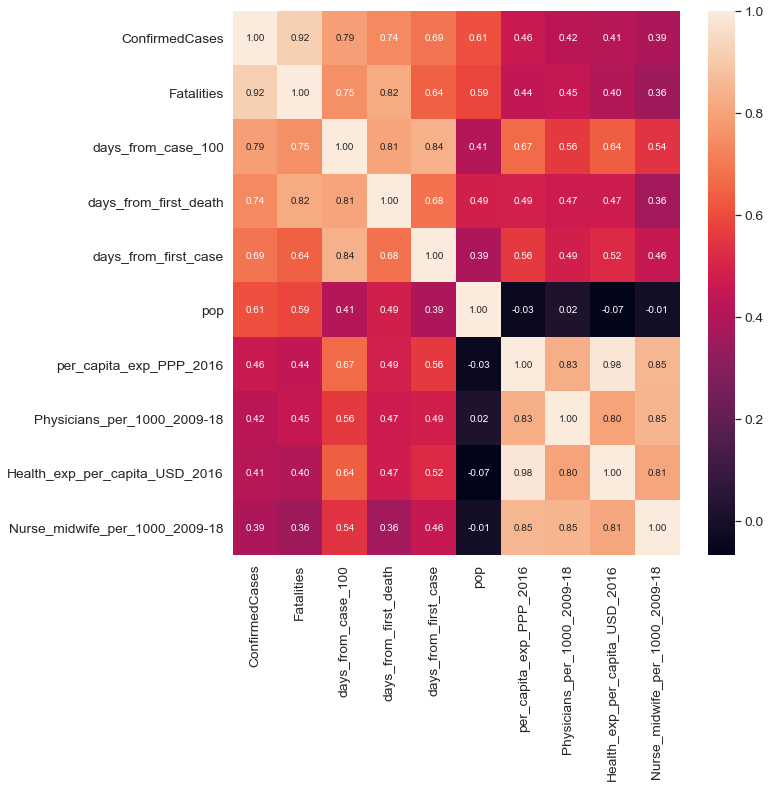

In [27]:
import scipy as sp 
cor_abs = abs(train3.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='ConfirmedCases').index
cor = np.array(sp.stats.spearmanr(train3[cor_cols].values))[0]
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, annot_kws={'size':10}, 
            xticklabels=cor_cols.values, yticklabels=cor_cols.values)

다중공선성이 너무 높아ㅠㅠㅠ

In [28]:
train3.columns

Index(['ConfirmedCases', 'Fatalities', 'pop', 'density', 'medianage',
       'urbanpop', 'hospibed', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64',
       'sex65plus', 'sexratio', 'lung', 'femalelung', 'malelung',
       'Health_exp_pct_GDP_2016', 'Health_exp_public_pct_2016',
       'Health_exp_out_of_pocket_pct_2016', 'Health_exp_per_capita_USD_2016',
       'per_capita_exp_PPP_2016', 'External_health_exp_pct_2016',
       'Physicians_per_1000_2009-18', 'Nurse_midwife_per_1000_2009-18',
       'Specialist_surgical_per_1000_2008-18',
       'Completeness_of_birth_reg_2009-18', 'label_country',
       'days_from_first_case', 'days_from_first_death', 'days_from_case_100'],
      dtype='object')

In [30]:
# 다중공선성 높은 변수 제거
train3 = train3.drop(['Fatalities', 'days_from_first_death', 'days_from_case_100'], axis=1)

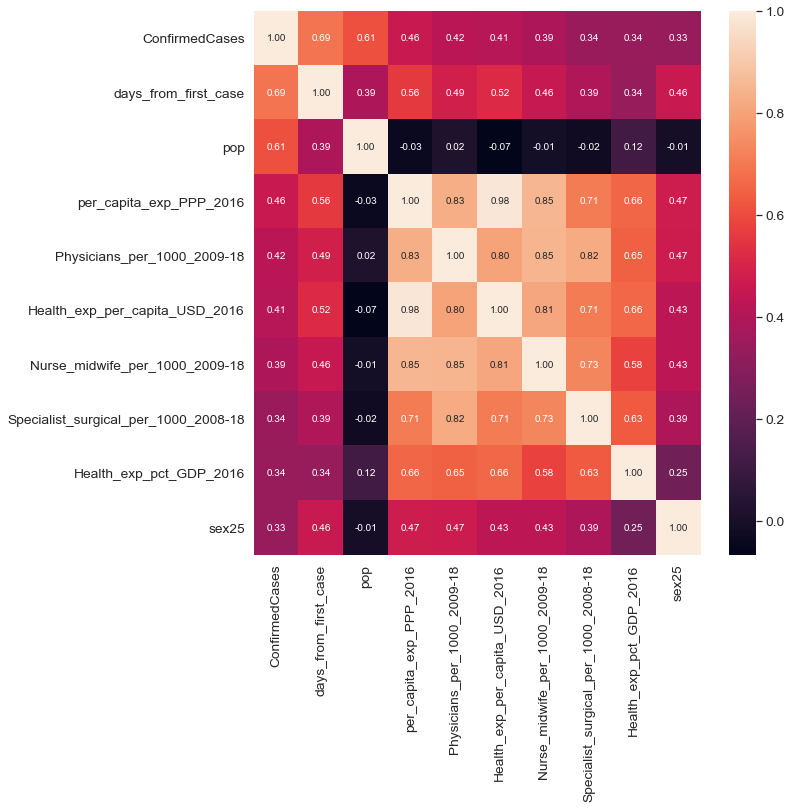

In [31]:
import scipy as sp 
cor_abs = abs(train3.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='ConfirmedCases').index
cor = np.array(sp.stats.spearmanr(train3[cor_cols].values))[0]
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, annot_kws={'size':10}, 
            xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [33]:
train.shape

(313, 31)